<a href="https://colab.research.google.com/github/Ekalabya3/Abhilash-2D2V/blob/main/Copy_of_Abhilash_2D_PIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import numpy as np
from scipy.fft import fftfreq, fft2, ifft2
import matplotlib.pyplot as plt

In [65]:
def periodic_particles(x, y, length):

    rem_x = x % length;
    if x > length:
      x = rem_x;
    elif x < 0:
      x = length - rem_x;

    rem_y = y % length
    if y > length:
      y = rem_y;
    elif y < 0:
      y = length - rem_y ;

    return x, y

In [66]:
def ghost(rho):
    Nx, Ny = rho.shape
    for i in range(Nx):
        rho[i, 0] = rho[i, Ny - 2]
        rho[i, Ny - 1] = rho[i, 1]

    for j in range(Ny):
        rho[0, j] = rho[Nx - 2, j]
        rho[Nx - 1, j] = rho[1, j]
    return rho

In [67]:
def charge_density(pos_x, pos_y, dx, dy, length):    #DONE

    charge_density = np.zeros((int(ncell ** 0.5)+1  , int(ncell ** 0.5)+1 ))    # + 2                             #+ 2*nghost

    # LOOPING
    for p in range(nparticles):
        pos_x[p], pos_y[p] = periodic_particles(pos_x[p], pos_y[p], length)

        # GRID POINT FINDER
        i = int(pos_x[p] / dx)  # +1
        j = int(pos_y[p] / dy)  # +1

        # FRACTION FINDER
        x_frac = ((pos_x[p]) - (i * dx)) / dx   #+dx
        y_frac = ((pos_y[p])  - (j * dy)) / dy   #+dy
        # WEIGHT FINDER
        weight_ii  = (1 - x_frac) * (1 - y_frac)    # FOR X=0, Y=0
        weight_ji  = x_frac * (1 - y_frac)          # FOR X=1, Y=0
        weight_ij  = (1 - x_frac) * y_frac          # FOR X=0, Y=1
        weight_jj  = x_frac * y_frac                # FOR X=1, Y=1

        charge_density[i][j]     =   charge_density[i][j]     + (particle_charge * weight_ii)           #/ (dx*dy)
        charge_density[(i+1)][j]   =   charge_density[(i+1)][j]   + (particle_charge * weight_ji)       #/ (dx*dy)
        charge_density[i][(j+1)]   =   charge_density[i][(j+1)]   + (particle_charge * weight_ij)       #/ (dx*dy)
        charge_density[(i+1)][(j+1)] =   charge_density[(i+1)][(j+1)] + (particle_charge * weight_jj)   #/ (dx*dy)


        #transpose_charge_density = np.transpose(charge_density_without_ghost)
        #rho_1 = (np.flip(transpose_charge_density, 0)) / (dx*dy)

        rho_1 = charge_density / (dx * dy)

    return  rho_1

In [68]:
def calculate_background_charge_density(dx, dy, length, particle_charge, nparticles):  #DONE

    # FIRST: TOTAL CHARGE CALCULATION
    total_particle_charge = particle_charge * nparticles

    # SECOND: TOTAL NUMBER OF GRID POINTS
    num_x_grid_points = int(ncell ** 0.5) + 1
    num_y_grid_points = int(ncell ** 0.5) + 1
    total_grid_points = num_x_grid_points * num_y_grid_points

    # THIRD: CHARGE DENSITY BY BACKGROUND PARTICLES (IONS)
    background_charge_density = (np.ones((num_x_grid_points, num_y_grid_points)) * (-total_particle_charge / total_grid_points)) / (dx * dy)  #(length*length)

    #background_charge_density_frame = np.zeros((num_x_grid_points + 2, num_y_grid_points + 2))
    #background_charge_density_frame [1:-1, 1:-1] = background_charge_density

    return background_charge_density#, background_charge_density_frame

In [69]:
def poisson_solver(rho, dx, dy):
    # Calculate Wavenumbers
    k_x = fftfreq(rho.shape[1], dx)
    k_y = fftfreq(rho.shape[0], dy)

    # Compute Fourier transform of charge density
    rho_hat = fft2(rho)

    # Compute potential in Fourier space
    kx_grid, ky_grid = np.meshgrid(k_x, k_y, indexing='ij')
    kx_grid_sq = kx_grid ** 2
    ky_grid_sq = ky_grid ** 2
    k_sq = kx_grid_sq + ky_grid_sq

    # Avoid division by zero at zero frequency
    k_sq[0, 0] = 1.0
    potential_hat = rho_hat / (4 * np.pi ** 2 * k_sq)

    # Compute electric field components in Fourier space
    E_x_hat = -1j * 2 * np.pi * kx_grid * potential_hat
    E_y_hat = -1j * 2 * np.pi * ky_grid * potential_hat

    # Compute inverse Fourier transform to get electric field in real space
    E_x = np.real(ifft2(E_x_hat))
    E_y = np.real(ifft2(E_y_hat))
    electric_potential = np.real(ifft2(potential_hat))

    return E_x, E_y, k_sq, electric_potential

In [70]:
def interpolate_field (pos_x, pos_y, dx, dy, length, E_x, E_y):

    Ex_at_particle = np.zeros(len(pos_x))
    Ey_at_particle = np.zeros(len(pos_y))

    # LOOPING
    for p in range(nparticles):
        pos_x[p], pos_y[p] = periodic_particles(pos_x[p], pos_y[p], length)

        # GRID POINT FINDER
        i = (int(pos_x[p] / dx)) # +1
        j = (int(pos_y[p] / dy)) # +1

        # FRACTION FINDER
        x_frac = ((pos_x[p]) - (i * dx)) / dx  #+dx
        y_frac = ((pos_y[p]) - (j * dy)) / dy#+dy

        # WEIGHT FINDER
        weight_ii  = (1 - x_frac) * (1 - y_frac)    # FOR X=0, Y=0
        weight_ji  = x_frac * (1 - y_frac)          # FOR X=1, Y=0
        weight_ij  = (1 - x_frac) * y_frac          # FOR X=0, Y=1
        weight_jj  = x_frac * y_frac                # FOR X=1, Y=1

        Ex_at_particle[p] = weight_ii * E_x[i][j] + weight_ji * E_x[(i+1)][j] + weight_ij * E_x[i][(j+1)] + weight_jj * E_x[(i+1)][(j+1)]
        Ey_at_particle[p] = weight_ii * E_y[i][j] + weight_ji * E_y[(i + 1)][j] + weight_ij * E_y[i][(j + 1)] + weight_jj * E_y[(i + 1)][(j + 1)]
        force_x = particle_charge * Ex_at_particle[p]
        force_y = particle_charge * Ey_at_particle[p]
        acc_x = force_x / particle_mass
        acc_y = force_y / particle_mass

    return Ex_at_particle, Ey_at_particle, force_x, force_y, acc_x, acc_y

In [71]:
def kinetic_energy(vel_x, vel_y, particle_mass):
    vel_sq = vel_x**2 + vel_y**2
    vel_resultant = np.sqrt(vel_sq)
    ke_particle = 0.5 * particle_mass * vel_resultant

    # Calculate total kinetic energy of the system
    ke_system = np.sum(ke_particle)

    return ke_particle, ke_system, vel_resultant

In [72]:
nparticles =        8000   # 100000
ncell =             100    # 10000
length =            10                                           # DO NOT CHANGE
n_step =            2500
t =                 0
dt =                0.01
particle_charge =   1
particle_mass =     1
iteration =         0

In [73]:
position_x = np.random.uniform(0, length, nparticles)
position_y = np.random.uniform(0, length, nparticles)
vel_x = np.random.uniform(-0.5, 0.5, nparticles)
vel_y = np.random.uniform(-0.5, 0.5, nparticles)

In [74]:
dx = length / abs(ncell ** 0.5 -2)
dy = length / abs(ncell ** 0.5 -2)

In [75]:
#pos_x_list = []
#vel_x_list = []
#rho_total_list = []
ke_system_list = []
timesteps_list = []

In [76]:
' TESTS '
"""
rho_electron = charge_density(position_x, position_y, dx, dy, length)
print("RHO_ELECTRON \n", rho_electron)
print("Total charge electron : ", np.sum(rho_electron))

background_charge_density, background_charge_density_frame = calculate_background_charge_density(dx, dy, length, particle_charge, nparticles)
print("RHO_Background \n", background_charge_density)
print("RHO_Background frame \n", background_charge_density_frame)
print("Total background charge : ", np.sum(background_charge_density))

rho_total = background_charge_density_frame + rho_electron
print("RHO total \n", rho_total)
print("Total charge system : ", np.sum(rho_total))

rho = ghost(rho_total)
print("RHO WITH GHOST \n", rho_total)

E_x_at_grid, E_y_at_grid, k_sq, electric_potential_grid = poisson_solver(rho_total, dx, dy)
print(" EX AT GRID : \n",E_x_at_grid)
print(np.sum(E_x_at_grid))
print(" EY AT GRID : \n",E_y_at_grid)
print(np.sum(E_y_at_grid))
print("K SQUARE : \n",k_sq)
print(np.sum(k_sq))
print(" Electric potential at grid : \n",electric_potential_grid)
print(np.sum(electric_potential_grid))

Ex_at_particle, Ey_at_particle, force_x, force_y, acc_x, acc_y = interpolate_field (position_x, position_y, dx, dy, length, E_x_at_grid, E_y_at_grid)
print(" EX AT PARTICLE : \n",Ex_at_particle)
print(np.sum(Ex_at_particle))
print(" EY AT PARTICLE : \n",Ey_at_particle)
print(np.sum(Ey_at_particle))
"""

'\nrho_electron = charge_density(position_x, position_y, dx, dy, length)\nprint("RHO_ELECTRON \n", rho_electron)\nprint("Total charge electron : ", np.sum(rho_electron))\n\nbackground_charge_density, background_charge_density_frame = calculate_background_charge_density(dx, dy, length, particle_charge, nparticles)\nprint("RHO_Background \n", background_charge_density)\nprint("RHO_Background frame \n", background_charge_density_frame)\nprint("Total background charge : ", np.sum(background_charge_density))\n\nrho_total = background_charge_density_frame + rho_electron\nprint("RHO total \n", rho_total)\nprint("Total charge system : ", np.sum(rho_total))\n\nrho = ghost(rho_total)\nprint("RHO WITH GHOST \n", rho_total)\n\nE_x_at_grid, E_y_at_grid, k_sq, electric_potential_grid = poisson_solver(rho_total, dx, dy)\nprint(" EX AT GRID : \n",E_x_at_grid)\nprint(np.sum(E_x_at_grid))\nprint(" EY AT GRID : \n",E_y_at_grid)\nprint(np.sum(E_y_at_grid))\nprint("K SQUARE : \n",k_sq)\nprint(np.sum(k_sq))

In [77]:

for step in range(n_step):
    timesteps_list.append(iteration)
    #pos_x_list = position_x
    #print(" POSITION X COORDINATES FOR EACH ITERATIONS \n", pos_x_list)
    #vel_x_list.append(vel_x)

    ke_particle, ke_system, vel_resultant = kinetic_energy(vel_x, vel_y, particle_mass)
    ke_system_list.append(ke_system)


    rho_electron = charge_density(position_x, position_y, dx, dy, length)
    background_charge_density= calculate_background_charge_density(dx, dy, length, particle_charge, nparticles)   #, background_charge_density_frame
    rho_total = background_charge_density + rho_electron
    #rho = ghost(rho_total)

    E_grid_x, E_grid_y, k_square, electric_potential_grid = poisson_solver(rho_total, dx, dy)

    Ex_at_particle, Ey_at_particle, force_x, force_y, acceleration_x, acceleration_y = interpolate_field(position_x, position_y, dx, dy, length, E_grid_x, E_grid_y)

    vx_half = vel_x + (0.5 * dt * acceleration_x)
    vy_half = vel_y + (0.5 * dt * acceleration_y)

    position_x += vx_half * dt
    position_y += vy_half * dt

    rho_electron = charge_density(position_x, position_y, dx, dy, length)
    background_charge_density = calculate_background_charge_density(dx, dy, length, particle_charge, nparticles)    #, background_charge_density_frame
    rho_total = background_charge_density + rho_electron
    #rho = ghost(rho_total)

    E_grid_x, E_grid_y, k_square, electric_potential_grid = poisson_solver(rho_total, dx, dy)

    Ex_at_particle, Ey_at_particle, force_x, force_y, acceleration_x, acceleration_y = interpolate_field(position_x, position_y, dx, dy, length, E_grid_x, E_grid_y)

    vel_x = vx_half + 0.5 * dt * acceleration_x
    vel_y = vy_half + 0.5 * dt * acceleration_y

    iteration += 1
    print("ITERATION : ", iteration)



    # Plotting histogram
    #plt.hist(vel_resultant, bins=150, density=True, alpha=0.75)
    #plt.xlabel('Velocity')
    #plt.ylabel('Probability Density')
    #plt.title('Probability Distribution of Particle Velocities')
    #plt.grid(True)
    #plt.xlim([0, 1])  # Replace min_velocity and max_velocity with your desired limits
    #plt.ylim([0, 20])
    #plt.show()
    '''
    plt.imshow(E_grid_x, origin='lower', cmap='viridis')
    plt.colorbar(label='Charge Density')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Charge Density Heatmap')
    plt.show()
    '''
    t += dt


ITERATION :  1
ITERATION :  2
ITERATION :  3
ITERATION :  4
ITERATION :  5
ITERATION :  6
ITERATION :  7
ITERATION :  8
ITERATION :  9
ITERATION :  10
ITERATION :  11
ITERATION :  12
ITERATION :  13
ITERATION :  14
ITERATION :  15
ITERATION :  16
ITERATION :  17
ITERATION :  18
ITERATION :  19
ITERATION :  20
ITERATION :  21
ITERATION :  22
ITERATION :  23
ITERATION :  24
ITERATION :  25
ITERATION :  26
ITERATION :  27
ITERATION :  28
ITERATION :  29
ITERATION :  30
ITERATION :  31
ITERATION :  32
ITERATION :  33
ITERATION :  34
ITERATION :  35
ITERATION :  36
ITERATION :  37
ITERATION :  38
ITERATION :  39
ITERATION :  40
ITERATION :  41
ITERATION :  42
ITERATION :  43
ITERATION :  44
ITERATION :  45
ITERATION :  46
ITERATION :  47
ITERATION :  48
ITERATION :  49
ITERATION :  50
ITERATION :  51
ITERATION :  52
ITERATION :  53
ITERATION :  54
ITERATION :  55
ITERATION :  56
ITERATION :  57
ITERATION :  58
ITERATION :  59
ITERATION :  60
ITERATION :  61
ITERATION :  62
ITERATION :  63
I

In [78]:
'''
#print("END POSITION X COORDINATES : \n ",pos_x_list)
print("Length of timesteps_list:", len(timesteps_list))
print("Length of ke_system_list:", len(ke_system_list))
'''

'\n#print("END POSITION X COORDINATES : \n ",pos_x_list)\nprint("Length of timesteps_list:", len(timesteps_list))\nprint("Length of ke_system_list:", len(ke_system_list))\n'

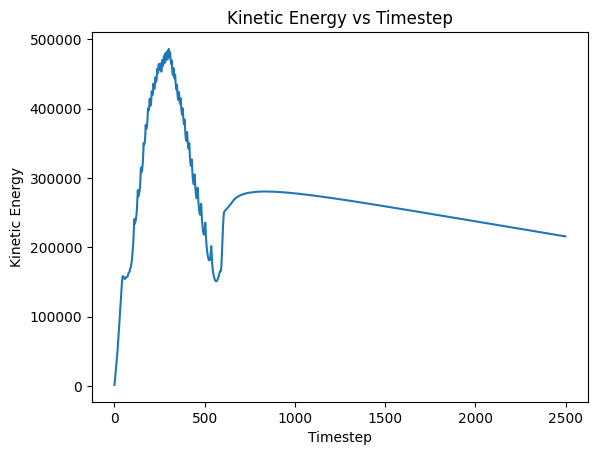

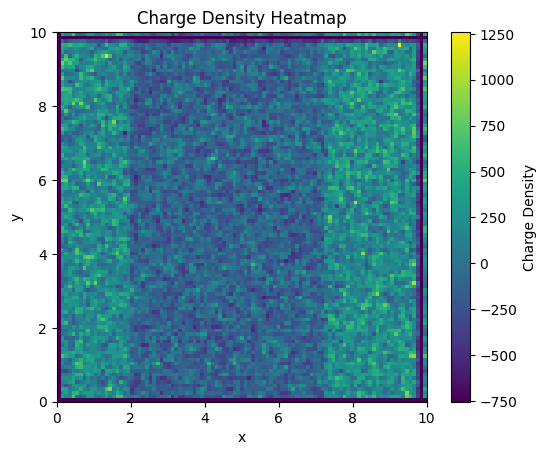

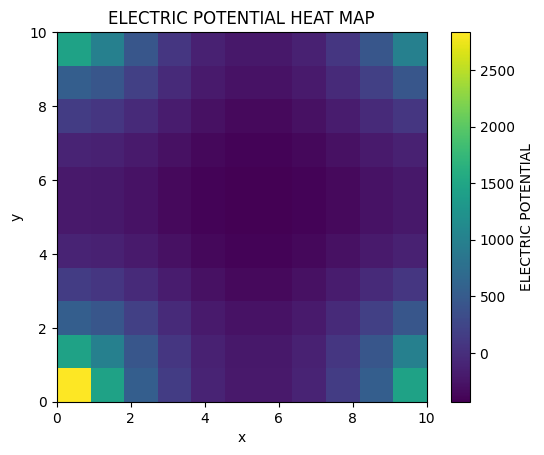

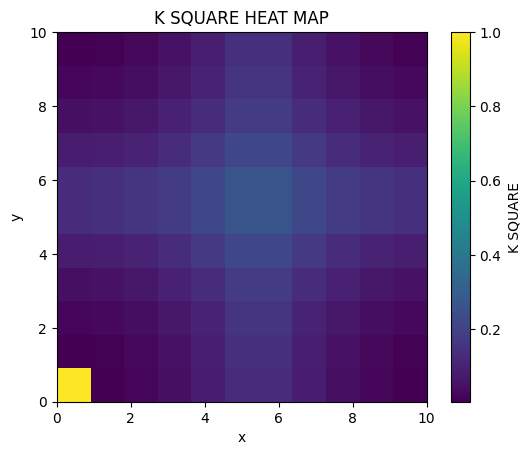

"\nplt.imshow(rho_electron, extent=(0, length, 0, length), origin='lower', cmap='viridis')\nplt.colorbar(label='Charge Density')\nplt.xlabel('x')\nplt.ylabel('y')\nplt.title('Charge Density Heatmap')\nplt.show()\n\nplt.imshow(background_charge_density, extent=(0, length, 0, length), origin='lower', cmap='viridis')\nplt.colorbar(label='Charge Density')\nplt.xlabel('x')\nplt.ylabel('y')\nplt.title('Charge Density Heatmap')\nplt.show()\n\nplt.imshow(rho_total, extent=(0, length, 0, length), origin='lower', cmap='viridis')\nplt.colorbar(label='Charge Density')\nplt.xlabel('x')\nplt.ylabel('y')\nplt.title('Charge Density Heatmap')\nplt.show()\n"

In [79]:

plt.plot(timesteps_list, ke_system_list, linestyle='-')
plt.title('Kinetic Energy vs Timestep')
plt.xlabel('Timestep')
plt.ylabel('Kinetic Energy')
#plt.grid(True)
plt.show()




plt.imshow(rho, extent=(0, length, 0, length), origin='lower', cmap='viridis')
plt.colorbar(label='Charge Density')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Charge Density Heatmap')
plt.show()


plt.imshow(electric_potential_grid, extent=(0, length, 0, length), origin='lower', cmap='viridis')
plt.colorbar(label='ELECTRIC POTENTIAL')
plt.xlabel('x')
plt.ylabel('y')
plt.title('ELECTRIC POTENTIAL HEAT MAP')
plt.show()

plt.imshow(k_square, extent=(0, length, 0, length), origin='lower', cmap='viridis')
plt.colorbar(label='K SQUARE')
plt.xlabel('x')
plt.ylabel('y')
plt.title('K SQUARE HEAT MAP')
plt.show()



'''
plt.imshow(rho_electron, extent=(0, length, 0, length), origin='lower', cmap='viridis')
plt.colorbar(label='Charge Density')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Charge Density Heatmap')
plt.show()

plt.imshow(background_charge_density, extent=(0, length, 0, length), origin='lower', cmap='viridis')
plt.colorbar(label='Charge Density')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Charge Density Heatmap')
plt.show()

plt.imshow(rho_total, extent=(0, length, 0, length), origin='lower', cmap='viridis')
plt.colorbar(label='Charge Density')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Charge Density Heatmap')
plt.show()
'''